In [23]:
priority = {
        '¬': 0, 
        '∧': 1,
        '∨': 2,
        '→': 3,
        '(': 4 
}
operators = ['¬', '∧', '∨', '→']

In [24]:
clg = {
    'not': '¬',
    'and': '∧', 
    'or': '∨', 
    'if': '→'
}

In [25]:

def split(s: str) -> list:
    ans = []
    temp = ''
    for i in s:
        if i in operators or i in '()':
            ans.append(temp)
            temp = ''
            ans.append(i)
        else:
            temp += i
    if temp:
        ans.append(temp)
    ans = [i for i in ans if i != '']
    return ans

def postfixer(ls: list) -> list:
    stack = []
    ans = []
    for i in ls:
        if i in operators or i in '()':
            if i == ')':
                while(stack[-1] != '('):
                    ans.append(stack[-1])
                    stack.pop()
                stack.pop()
                continue
            if i == '(':
                stack.append('(')
                continue
            while len(stack) > 0 and priority[i] > priority[stack[-1]]:
                ans.append(stack[-1])
                stack.pop()
            stack.append(i)
        else:
            ans.append(i)
    while len(stack) > 0:
        ans.append(stack[-1])
        stack.pop()
    return ans

In [26]:
postfixer(split('a∨¬(q∨r)'))

['a', 'q', 'r', '∨', '¬', '∨']

In [27]:
def sequence_creator(ls: list) -> list:
    sq = []
    stack = []
    for i in ls:
        if i in operators:
            if i == '¬':
                sq.append(stack[-1] + i)
                stack.pop()
                stack.append(sq[-1])
            else:
                sq.append(stack[-2] + stack[-1] + i)
                stack.pop()
                stack.pop()
                stack.append(sq[-1])
        else:
            sq.append(i)
            stack.append(i)
        #uniqeness
        if sq.count(sq[-1]) > 1:
                    sq.pop()
    return sq


In [28]:
sequence_creator(postfixer(split('(p∨(q∧r))→((p∨q)∧(p∨r))')))

['p', 'q', 'r', 'qr∧', 'pqr∧∨', 'pq∨', 'pr∨', 'pq∨pr∨∧', 'pqr∧∨pq∨pr∨∧→']

In [29]:
def last_two_stack_history(ls: list) -> list:
    sq = []
    stack = []
    hist = [[], [], []]
    for index, i in enumerate(ls):
        if i in operators:
            if i == '¬':
                sq.append(stack[-1] + [i])
                stack.pop()
                stack.append(sq[-1])
            else:
                sq.append(stack[-2] + stack[-1] + [i])
                stack.pop()
                stack.pop()
                stack.append(sq[-1])
        else:
            sq.append([i])
            stack.append([i])
        if index >= len(ls)-3:
            for j in stack:
                hist[index-len(ls)+3].append(j)
    return hist  

In [30]:
last_two_stack_history(postfixer(split('(p∨(q∧r))→((p∨q)∧(p∨r))')))

[[['p', 'q', 'r', '∧', '∨'], ['p', 'q', '∨'], ['p', 'r', '∨']],
 [['p', 'q', 'r', '∧', '∨'], ['p', 'q', '∨', 'p', 'r', '∨', '∧']],
 [['p', 'q', 'r', '∧', '∨', 'p', 'q', '∨', 'p', 'r', '∨', '∧', '→']]]

In [31]:
def tablue_rules(ls: list) -> str:
    hist = last_two_stack_history(ls)
    temp = ''
    cnt = 0
    if ls[-1] == clg['not']:
        if len(ls) > 1 and ls[-2] == clg['not'] : 
            return ('double_not', hist[-3])
        if ls[-2] not in operators : 
            return ('atomic')
        temp = 'not'
        cnt = -1
    if ls[-1 + cnt] == clg['or']:
        return ('or' + temp, hist[-2 + cnt])
    elif ls[-1 + cnt] == clg['and']:
        return ('and' + temp, hist[-2 + cnt])
    elif ls[-1 + cnt] == clg['if']:
        return ('if' + temp, hist[-2 + cnt])
    else:
        return ('atomic')
tablue_rules(postfixer(split('(p∨(q∧r))→((p∨q)∧(p∨r))')))


('if', [['p', 'q', 'r', '∧', '∨'], ['p', 'q', '∨', 'p', 'r', '∨', '∧']])

In [32]:
def is_atomic(ls: list) -> bool:
    return len(ls) == 1 and ls[0].isascii() or (len(ls) == 2 and ls[1] == clg['not'] and ls[0].isascii())

In [33]:
def give_model(atoms_carry: dict) -> dict:
    print({key: (val == 2) for key, val in atoms_carry.items()})

In [34]:
def run_tablue(assump_carry: list=[], atoms_carry=None, verbose: bool=False) -> str:
    if atoms_carry == None:
        atoms_carry = dict()

    if verbose:
        print(assump_carry, atoms_carry)
        

    if assump_carry == []:
        give_model(atoms_carry)
        return 'open'
    now = assump_carry.pop()
    while(is_atomic(now)):
        if len(now) == 2 and atoms_carry.get(now[0], 0) != -2:
            atoms_carry[now[0]] = atoms_carry.get(now[0], 1) * -2
        elif len(now) == 1 and atoms_carry.get(now[0], 0) != 2:
            atoms_carry[now[0]] = atoms_carry.get(now[0], 1) * 2
        if -4 in atoms_carry.values():
            return 'closed'   
        if len(assump_carry) == 0:
            give_model(atoms_carry)
            return 'open'
        now = assump_carry.pop()

    if -4 in atoms_carry.values():
            return 'closed'   
    

    kind, parts = tablue_rules(now)
    a, b = 'closed', 'closed'
    if kind == 'or':
        a = run_tablue(assump_carry + [parts[0]], atoms_carry.copy(), verbose)
        b = run_tablue(assump_carry + [parts[1]], atoms_carry.copy(), verbose)
    if kind == 'and':
        a = run_tablue(assump_carry + [parts[0], parts[1]], atoms_carry.copy(), verbose)
    if kind == 'if':
        a = run_tablue(assump_carry + [parts[0] + [clg['not']]], atoms_carry.copy(), verbose)
        b = run_tablue(assump_carry + [parts[1]], atoms_carry.copy(), verbose)
    if kind == 'ornot':
        a = run_tablue(assump_carry + [parts[0] + [clg['not']], parts[1] + [clg['not']]], atoms_carry.copy(), verbose)
    if kind == 'andnot':
        a = run_tablue(assump_carry + [parts[0] + [clg['not']]], atoms_carry.copy(), verbose)
        b = run_tablue(assump_carry + [parts[1] + [clg['not']]], atoms_carry.copy(), verbose)
    if kind == 'ifnot':
        a = run_tablue(assump_carry + [parts[0], parts[1] + [clg['not']]], atoms_carry.copy(), verbose)
    if kind == 'double_not':
        a = run_tablue(assump_carry + [parts[0]], atoms_carry.copy(), verbose)
        
    if a != 'closed' or b != 'closed':
        return 'open'
    else:
        return 'closed'

In [35]:
run_tablue([postfixer(split('¬((p∨(q∧r))→((p∨q)∧(p∨r)))'))], verbose=True)

[['p', 'q', 'r', '∧', '∨', 'p', 'q', '∨', 'p', 'r', '∨', '∧', '→', '¬']] {}
[['p', 'q', 'r', '∧', '∨'], ['p', 'q', '∨', 'p', 'r', '∨', '∧', '¬']] {}
[['p', 'q', 'r', '∧', '∨'], ['p', 'q', '∨', '¬']] {}
[['p', 'q', 'r', '∧', '∨'], ['p', '¬'], ['q', '¬']] {}
[['p']] {'q': -2, 'p': -2}
[['q', 'r', '∧']] {'q': -2, 'p': -2}
[['q'], ['r']] {'q': -2, 'p': -2}
[['p', 'q', 'r', '∧', '∨'], ['p', 'r', '∨', '¬']] {}
[['p', 'q', 'r', '∧', '∨'], ['p', '¬'], ['r', '¬']] {}
[['p']] {'r': -2, 'p': -2}
[['q', 'r', '∧']] {'r': -2, 'p': -2}
[['q'], ['r']] {'r': -2, 'p': -2}


'closed'

In [36]:
def check_totologies(s: str) -> str:
    postfixed = postfixer(split(s))
    res = run_tablue([postfixed + [clg['not']]])
    if res == 'closed':
        print('Thats True!')
    else:
        print('Its not totology!')
    

In [37]:
check_totologies('¬((p∨(q∧r))→((p∨q)∧(p∨r)))')

{'q': False, 'p': False}
{'r': False, 'p': False}
{'p': True}
{'p': True, 'q': True}
{'r': True, 'p': True}
{'r': True, 'q': True}
Its not totology!


### ! not provided atoms in models means it is arbitary

### Drawing


In [38]:
def postfix_to_infix(ls):
    stack = []
    ans = ''
    for i in ls:
        if i in operators:
            if i == clg['not']:
                stack[-1] = clg['not'] + '(' + stack[-1] + ')'
            else:
                temp = '(' + stack[-2] + ' ' + i + ' ' + stack[-1] + ')'
                stack.pop()
                stack.pop()
                stack.append(temp)
        else:
            stack.append(i)
    return stack[-1]

In [39]:
postfix_to_infix(postfixer(split('¬((p∨(q∧r))→((p∨q)∧(p∨r)))')))

'¬(((p ∨ (q ∧ r)) → ((p ∨ q) ∧ (p ∨ r))))'

In [40]:
!pip install graphviz

In [41]:
from graphviz import Digraph

g = Digraph('tablue_tree')
node_counter = 0

def run_and_draw_tablue(assump_carry=[], atoms_carry=None, verbose=False):
    global g, node_counter

    if atoms_carry is None:
        atoms_carry = dict()

    if assump_carry == []:
        give_model(atoms_carry)
        return 'open'
    
    if verbose:
        print(assump_carry, atoms_carry)

    now = assump_carry.pop()

   

    while is_atomic(now):
        node_label = f'{postfix_to_infix(now)}'
        g.node(str(node_counter), node_label)
        node_counter += 1
        print(now)
        if len(now) == 2 and atoms_carry.get(now[0], 0) != -2:
            atoms_carry[now[0]] = atoms_carry.get(now[0], 1) * -2
        elif len(now) == 1 and atoms_carry.get(now[0], 0) != 2:
            atoms_carry[now[0]] = atoms_carry.get(now[0], 1) * 2

        if -4 in atoms_carry.values():
            node_label = 'X'
            g.node(str(node_counter), node_label, fillcolor='red', style='filled')
            node_counter += 1
            g.edge(str(node_counter-2), str(node_counter-1))
            return 'closed'
        

        if len(assump_carry) == 0:
            give_model(atoms_carry)
            return 'open'
        
        g.edge(str(node_counter-1), str(node_counter))

        now = assump_carry.pop()

    node_label = f'{postfix_to_infix(now)}'
    g.node(str(node_counter), node_label)
    node_counter += 1
    if -4 in atoms_carry.values():
        node_label = 'X'
        g.node(str(node_counter), node_label, fillcolor='red', style='filled')
        node_counter += 1
        g.edge(str(node_counter-2), str(node_counter-1))
        return 'closed'

    kind, parts = tablue_rules(now)
    print(kind, parts)
    a, b = 'closed', 'closed'

    now_node = node_counter-1
    if kind == 'or':
        g.edge(str(now_node), str(node_counter), label=kind)
        a = run_and_draw_tablue(assump_carry + [parts[0]], atoms_carry.copy(), verbose)
        g.edge(str(now_node), str(node_counter), label=kind)
        b = run_and_draw_tablue(assump_carry + [parts[1]], atoms_carry.copy(), verbose)

    
    if kind == 'and':
        g.edge(str(now_node), str(node_counter), label=kind)
        a = run_and_draw_tablue(assump_carry + [parts[0], parts[1]], atoms_carry.copy(), verbose)

    if kind == 'if':
        g.edge(str(now_node), str(node_counter), label=kind)
        a = run_and_draw_tablue(assump_carry + [parts[0] + [clg['not']]], atoms_carry.copy(), verbose)
        g.edge(str(now_node), str(node_counter), label=kind)
        b = run_and_draw_tablue(assump_carry + [parts[1]], atoms_carry.copy(), verbose)

    if kind == 'ornot':
        g.edge(str(now_node), str(node_counter), label=kind)
        a = run_and_draw_tablue(assump_carry + [parts[0] + [clg['not']], parts[1] + [clg['not']]], atoms_carry.copy(), verbose)

    if kind == 'andnot':
        g.edge(str(now_node), str(node_counter), label=kind)

        a = run_and_draw_tablue(assump_carry + [parts[0] + [clg['not']]], atoms_carry.copy(), verbose)
        g.edge(str(now_node), str(node_counter), label=kind)

        b = run_and_draw_tablue(assump_carry + [parts[1] + [clg['not']]], atoms_carry.copy(), verbose)

    if kind == 'ifnot':
        g.edge(str(now_node), str(node_counter), label=kind)

        a = run_and_draw_tablue(assump_carry + [parts[0], parts[1] + [clg['not']]], atoms_carry.copy(), verbose)

    if kind == 'double_not':
        g.edge(str(now_node), str(node_counter), label=kind)

        a = run_and_draw_tablue(assump_carry + [parts[0]], atoms_carry.copy(), verbose)

        
    if a != 'closed' or b != 'closed':
        return 'open'
    else:
        return 'closed'


print(run_and_draw_tablue(assump_carry=[postfixer(split('¬((p∧¬p)→(q))'))], verbose=True))

[['p', 'p', '¬', '∧', 'q', '→', '¬']] {}
ifnot [['p', 'p', '¬', '∧'], ['q']]
[['p', 'p', '¬', '∧'], ['q', '¬']] {}
['q', '¬']
and [['p'], ['p', '¬']]
[['p'], ['p', '¬']] {'q': -2}
['p', '¬']
['p']
closed


In [42]:
def check_totologies_draw(s, save=False):
    global g, node_counter
    g = Digraph('tree')
    node_counter = 0
    postfixed = postfixer(split(s))
    res = run_and_draw_tablue([postfixed + [clg['not']]])
    if res == 'closed':
        print('Thats True!')
    else:
        print('Its not totology!')

    display(g)
    
    if save:
        g.render('tree', format='png', cleanup=True)
    
    

ifnot [['p', 'q', 'r', '∧', '∨'], ['p', 'q', '∨', 'p', 'r', '∨', '∧']]
andnot [['p', 'q', '∨'], ['p', 'r', '∨']]
ornot [['p'], ['q']]
['q', '¬']
['p', '¬']
or [['p'], ['q', 'r', '∧']]
['p']
and [['q'], ['r']]
['r']
['q']
ornot [['p'], ['r']]
['r', '¬']
['p', '¬']
or [['p'], ['q', 'r', '∧']]
['p']
and [['q'], ['r']]
['r']
Thats True!


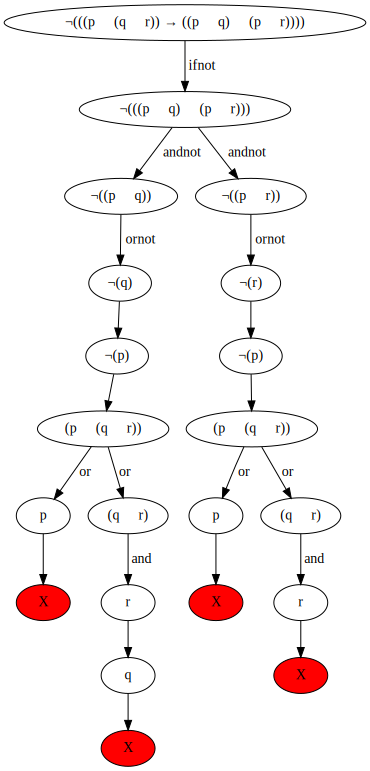

In [43]:
check_totologies_draw('(p∨(q∧r))→((p∨q)∧(p∨r))', save=True)

ornot [['p'], ['p', '¬']]
double_not [['p']]
['p']
['p', '¬']
Thats True!


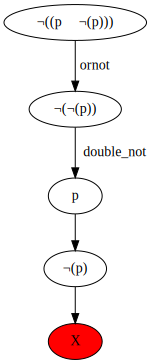

In [44]:
check_totologies_draw('p∨¬p')